In [1]:

import itertools
from functools import partial

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
import seaborn as sns
from jk_utils import (
    construct_vandermonde,
    grad_jacobi_polynomial_normalised,
    jacobi_gauss_lobatto,
    jacobi_polynomial_normalised,
    jacobi_polynomial,
    grad_jacobi_polynomial,
)
from utils import JacobiGL, constructD
from common import setup_plotting, PAPER_WIDTH_IN, OUTPUT_DIR, EXPORT_DPI

%load_ext autoreload
%autoreload 2

In [2]:
setup_plotting()

# a)
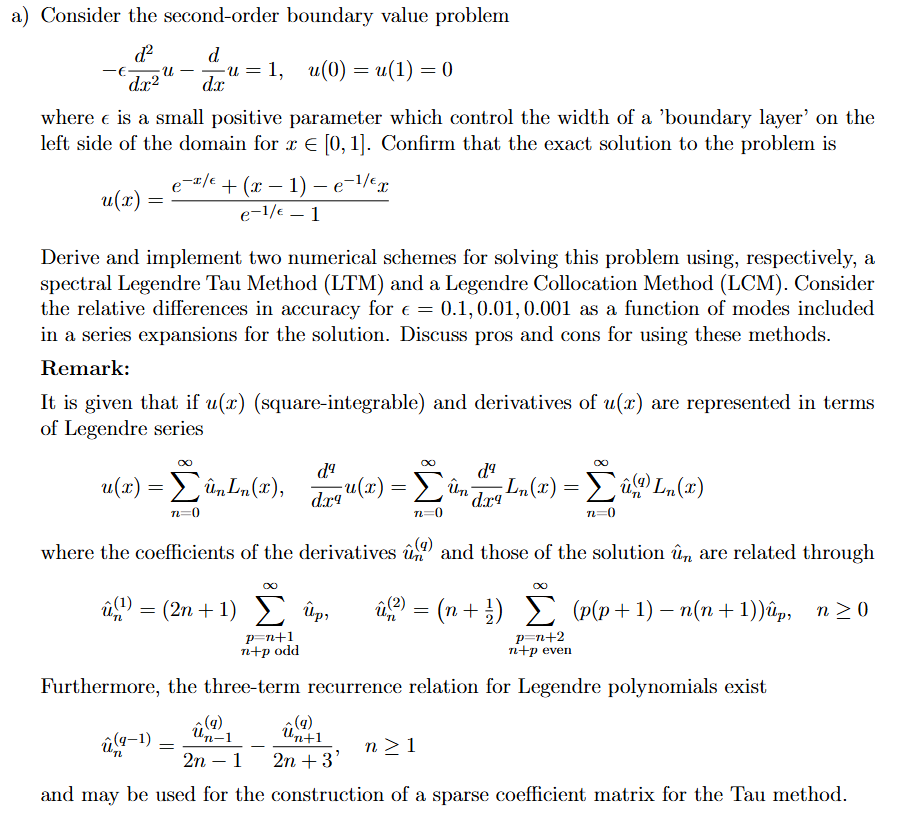

In [3]:
def u_func_1(x, epsilon):
    denom = np.exp(-1.0 / epsilon) - 1
    nom = +np.exp(-x / epsilon) + (x - 1) - np.exp(-1 / epsilon) * x
    return nom / denom


# Legendre
alpha = 0.0
beta = 0.0

# Let z be Jacobi domain, z ∈ [-1, 1]
a, b = 0.0, 1.0  # Domain


def jacobi_p(x: npt.NDArray, alpha: float, beta: float, n: int) -> npt.NDArray:
    """
    Evaluates first `n+1` Jacobi polynomials at points `x` with parameters `alpha` and `beta`.
    Reflects L2, slide 12.

    Arguments:
        x: Points at which to evaluate the polynomials, shape (m,)
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: Highest order polynomial to compute (must be positive)

    Returns: Array of shape (m, n+1) where each column corresponds to a Jacobi polynomial
        Note that this is essentially the Vandermonde matrix for Jacobi polynomials.
    """
    assert n >= 0, "n must be non-negative"

    P = np.empty((len(x), n + 1))

    P[:, 0] = 1.0
    if n == 0:
        return P

    P[:, 1] = 1 / 2 * (alpha - beta + (alpha + beta + 2) * x)
    if n == 1:
        return P

    for k in range(1, n):
        a_nm1_n = (
            2
            * (k + alpha)
            * (k + beta)
            / ((2 * k + alpha + beta + 1) * (2 * k + alpha + beta))
        )
        a_n_n = (alpha**2 - beta**2) / (
            (2 * k + alpha + beta + 2) * (2 * k + alpha + beta)
        )
        a_np1_n = (
            2
            * (k + 1)
            * (k + alpha + beta + 1)
            / ((2 * k + alpha + beta + 2) * (2 * k + alpha + beta + 1))
        )

        P[:, k + 1] = ((a_n_n + x) * P[:, k] - a_nm1_n * P[:, k - 1]) / a_np1_n

    return P


def grad_jacobi_p(x: npt.NDArray, alpha: float, beta: float, n: int) -> npt.NDArray:
    """
    Computes the gradient of the first `n+1` Jacobi polynomials at nodes `x`.
    Reflects L2, slide 15.

    Arguments:
        x: Points at which to evaluate the gradients, shape (m,)
        alpha: Jacobi parameter, $α > -1$
        beta: Jacobi parameter, $β > -1$
        n: Highest order polynomial to compute (must be positive)
    Returns: Array of shape (m, n+1) where each column corresponds to the gradient of a Jacobi polynomial
    """
    grad_p = np.empty((len(x), n + 1))

    for i in range(n + 1):
        if i == 0:
            p_i = np.zeros_like(x)
        else:
            p_i = jacobi_p(x, alpha + 1, beta + 1, i - 1)[:, i - 1]

        coeff = 1 / 2 * (alpha + beta + i + 1)
        grad_p[:, i] = coeff * p_i

    return grad_p


# Legend

## a - Spectral Legendre Tau Method

array([-1.        , -0.93548387, -0.87096774, -0.80645161, -0.74193548,
       -0.67741935, -0.61290323, -0.5483871 , -0.48387097, -0.41935484,
       -0.35483871, -0.29032258, -0.22580645, -0.16129032, -0.09677419,
       -0.03225806,  0.03225806,  0.09677419,  0.16129032,  0.22580645,
        0.29032258,  0.35483871,  0.41935484,  0.48387097,  0.5483871 ,
        0.61290323,  0.67741935,  0.74193548,  0.80645161,  0.87096774,
        0.93548387,  1.        ])

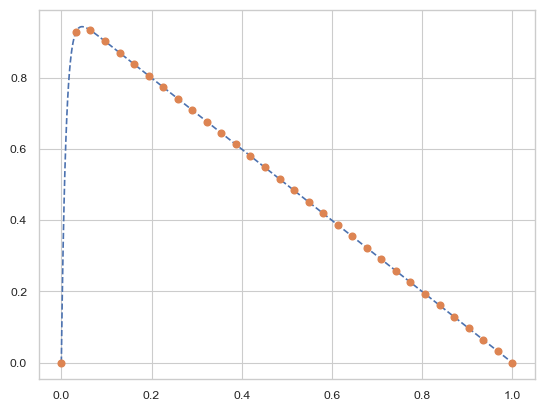

In [4]:
# We first solve Spectral Legendre Tau Method
N = 32
P = N - 1
epsilon = 0.01

# Build system matrix, L_N
a_coeff = -4.0 * epsilon
b_coeff = -2.0
c_coeff = 0.0

# Construct differentiation matrix
D = np.zeros((N, N))
for n in range(N):
    e_n = np.zeros(N)
    e_n[n] = 1.0

    # Use basis vectors as u_hat
    u_hat = e_n
    u_prime_hat = np.zeros_like(u_hat)

    # Correct Legendre differentiation rule:
    # u'_k = (2k+1) * sum_{p=k+1, p-k is odd}^N u_p
    for k in range(N):
        sum_val = 0.0
        for p in range(k + 1, N):
            if (p - k) % 2 == 1:
                sum_val += u_hat[p]
        u_prime_hat[k] = (2 * k + 1) * sum_val

    D[:, n] = u_prime_hat

L_N = a_coeff * D @ D + b_coeff * D + c_coeff * np.eye(N)
L_N.shape

# Construct A matrix where we sacrifice some rows for BCs
A = L_N.copy()
A[N - 2, :] = [1.0 for _ in range(N)]
A[N - 1, :] = [(-1) ** n for n in range(N)]

# Find nodal points
x_eval = np.linspace(0, 1, N, endpoint=True)
z_eval = 2 * x_eval - 1  # Map to [-1, 1]

# Now build RHS
V = jacobi_p(z_eval, alpha, beta, P)
display(z_eval)
f = np.zeros(N)

f = np.zeros(N)
f
f_hat = np.zeros(N)
f_hat[0] = 1.0
f_hat[N - 2] = 0.0
f_hat[N - 1] = 0.0
# D = constructD(z, alpha, beta)

# Now solve for coefficients
u_hat = np.linalg.solve(A, f_hat)


legendre_poly = np.polynomial.legendre.Legendre(u_hat)
u_hat = legendre_poly(z_eval)

# Now plot
x = np.linspace(0, 1, 500)
u_true = u_func_1(x, epsilon)

x_eval = np.linspace(0, 1, N, endpoint=True)

plt.plot(x, u_true, label="Exact solution", linestyle="dashed")
plt.plot(x_eval, u_hat, "o")


array([-1.        , -0.93548387, -0.87096774, -0.80645161, -0.74193548,
       -0.67741935, -0.61290323, -0.5483871 , -0.48387097, -0.41935484,
       -0.35483871, -0.29032258, -0.22580645, -0.16129032, -0.09677419,
       -0.03225806,  0.03225806,  0.09677419,  0.16129032,  0.22580645,
        0.29032258,  0.35483871,  0.41935484,  0.48387097,  0.5483871 ,
        0.61290323,  0.67741935,  0.74193548,  0.80645161,  0.87096774,
        0.93548387,  1.        ])

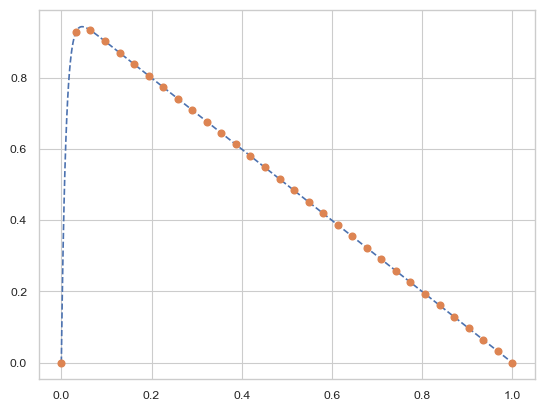

In [5]:
# We first solve Spectral Legendre Tau Method
N = 32
P = N - 1
epsilon = 0.01

# Build system matrix, L_N
a_coeff = -4.0 * epsilon
b_coeff = -2.0
c_coeff = 0.0

# Construct differentiation matrix
D = np.zeros((N, N))
for n in range(N):
    e_n = np.zeros(N)
    e_n[n] = 1.0

    # Use basis vectors as u_hat
    u_hat = e_n
    u_prime_hat = np.zeros_like(u_hat)

    # Correct Legendre differentiation rule:
    # u'_k = (2k+1) * sum_{p=k+1, p-k is odd}^N u_p
    for k in range(N):
        sum_val = 0.0
        for p in range(k + 1, N):
            if (p - k) % 2 == 1:
                sum_val += u_hat[p]
        u_prime_hat[k] = (2 * k + 1) * sum_val

    D[:, n] = u_prime_hat

L_N = a_coeff * D @ D + b_coeff * D + c_coeff * np.eye(N)
L_N.shape

# Construct A matrix where we sacrifice some rows for BCs
A = L_N.copy()
A[N - 2, :] = [1.0 for _ in range(N)]
A[N - 1, :] = [(-1) ** n for n in range(N)]

# Find nodal points
x_eval = np.linspace(0, 1, N, endpoint=True)
z_eval = 2 * x_eval - 1  # Map to [-1, 1]

# Now build RHS
V = jacobi_p(z_eval, alpha, beta, P)
display(z_eval)
f = np.ones(N)
f_hat = np.linalg.solve(V, f)

# Impose BCs, we override highest order modes for least error assuming
# monotonically decreasing modal coefficients
f_hat[-2] = 0.0
f_hat[-1] = 0.0

# Now solve for coefficients
u_hat = np.linalg.solve(A, f_hat)

legendre_poly = np.polynomial.legendre.Legendre(u_hat)
u_hat = legendre_poly(z_eval)

# Now plot
x = np.linspace(0, 1, 500)
u_true = u_func_1(x, epsilon)

x_eval = np.linspace(0, 1, N, endpoint=True)

plt.plot(x, u_true, label="Exact solution", linestyle="dashed")
plt.plot(x_eval, u_hat, "o")


## a - Legendre Collocation Method

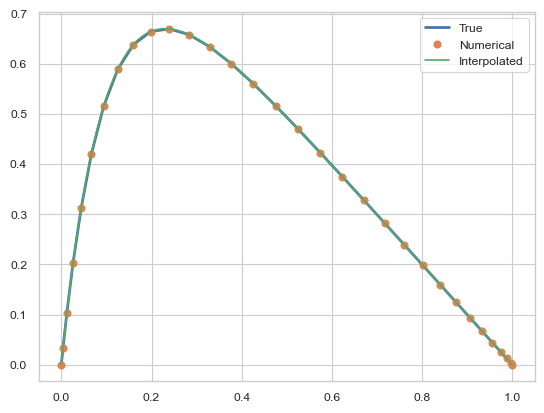

In [16]:
N_grid = 32
N = N_grid - 1  # Highest polynomial order

# Basis parameters
alpha = 0.0
beta = 0.0
basis_func = partial(jacobi_polynomial_normalised, alpha=alpha, beta=beta)
basic_func_grad = partial(
    grad_jacobi_polynomial_normalised, k=1, alpha=alpha, beta=beta
)

# Model parameters
epsilon = 0.1

z_gl, w_gl = jacobi_gauss_lobatto(N, alpha, beta)  # Includes boundaries, domain: [-1, 1]
# Uncomment to try equidistant grid
# z_gl = np.linspace(-1, 1, N_grid)
# w_gl = np.ones_like(z_gl) * 2.0 / (N_grid - 1)

x_gl = 0.5 * (b - a) * (z_gl + 1) + a  # Map to [a, b]
u_gl_true = u_func_1(x_gl, epsilon)

# Construct differentiation matrix
V = construct_vandermonde(z_gl, N + 1, basis_func)
V_z = construct_vandermonde(z_gl, N + 1, basic_func_grad)
D_z = np.linalg.solve(
    V.T, V_z.T
).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve

A = -4.0 * epsilon * np.eye(N + 1)
B = -2.0 * np.eye(N + 1)
C = np.zeros((N + 1, N + 1))

# Set up approximate operator
L_N = D_z @ A @ D_z + B @ D_z + C

# RHS
F = np.ones(N + 1)

# Enforce BCs
L_N[0, :] = 0.0
L_N[0, 0] = 1.0
L_N[-1, :] = 0.0
L_N[-1, -1] = 1.0
F[0] = 0.0
F[-1] = 0.0

# Solve
u_gl = np.linalg.solve(L_N, F)

# Compute interpolated solution
N_interp = 1000
z_gl_interp = np.linspace(-1, 1, N_interp)
x_gl_interp = 0.5 * (b - a) * (z_gl_interp + 1) + a  # Map to [a, b]
V_interp = construct_vandermonde(z_gl_interp, N + 1, basis_func)
I_n = np.linalg.solve(V.T, V_interp.T).T  # I_n = V_interp @ V^{-1}
u_interp = I_n @ u_gl

plt.plot(x_gl, u_gl_true, lw=2, label="True")
plt.plot(x_gl, u_gl, "o", label="Numerical")
plt.plot(x_gl_interp, u_interp, "-", label="Interpolated")
plt.legend()


In [7]:
from jk_utils import jacobi_gauss_quadrature

N=3
alpha = 0.0
beta = 0.0
jacobi_gauss_quadrature(N, alpha, beta)

c:\Users\jeppe\Documents\MEGA\Base\DTU\02689 Advanced Numerical Methods\Assignments\assignment_2\jk_utils.py:26: RuntimeWarning: invalid value encountered in divide
  -0.5 * (alpha**2 - beta**2) / ((h1 + 2.0) * h1)


(array([-0.86113631, -0.33998104,  0.33998104,  0.86113631]),
 array([0.34785485, 0.65214515, 0.65214515, 0.34785485]))

In [8]:
# Basis parameters
alpha = 0.0
beta = 0.0

use_normalised = False
if use_normalised:
    basis_func = partial(jacobi_polynomial_normalised, alpha=alpha, beta=beta)
    basic_func_grad = partial(
        grad_jacobi_polynomial_normalised, k=1, alpha=alpha, beta=beta
    )
else:
    basis_func = partial(jacobi_polynomial, alpha=alpha, beta=beta)
    basic_func_grad = partial(
        grad_jacobi_polynomial, alpha=alpha, beta=beta
    )

def u_func_1(x, epsilon):
    denom = np.exp(-1.0 / epsilon) - 1
    nom = +np.exp(-x / epsilon) + (x - 1) - np.exp(-1 / epsilon) * x
    return nom / denom

epsilons = [0.1, 0.01, 0.001]
N_grids = np.arange(3, 200, 1, dtype=int)
data = []
for epsilon, N_grid in itertools.product(epsilons, N_grids):
    N = N_grid - 1  # Highest polynomial order

    z_gl, w_gl = jacobi_gauss_lobatto(N, alpha, beta)  # Includes boundaries, domain: [-1, 1]
    # Uncomment to try equidistant grid
    # z_gl = np.linspace(-1, 1, N_grid)
    # w_gl = np.ones_like(z_gl) * 2.0 / (N_grid - 1)

    jacobian = (b-a)/2.0
    x_gl = jacobian * (z_gl + 1) + a  # Map to [a, b]
    u_gl_true = u_func_1(x_gl, epsilon)

    # Construct differentiation matrix
    V = construct_vandermonde(z_gl, N + 1, basis_func)
    V_z = construct_vandermonde(z_gl, N + 1, basic_func_grad)
    D_z = np.linalg.solve(
        V.T, V_z.T
    ).T  # D_z = = V_z @ V^{-1}, note transposes for right-solve
    A = -4.0 * epsilon * np.eye(N + 1)
    B = -2.0 * np.eye(N + 1)
    C = np.zeros((N + 1, N + 1))

    # Better numerics at cost of less generality
    D_z2 = D_z @ D_z
    a_coeff = -4.0 * epsilon
    b_coeff = -2.0
    c_coeff = 0.0

    # Set up approximate operator
    L_N = a_coeff * D_z2 + b_coeff * D_z + c_coeff

    # RHS
    F = np.ones(N + 1)

    # Enforce BCs
    L_N[0, :] = 0.0
    L_N[0, 0] = 1.0
    L_N[-1, :] = 0.0
    L_N[-1, -1] = 1.0
    F[0] = 0.0
    F[-1] = 0.0

    # Solve
    u_gl = np.linalg.solve(L_N, F)

    # Compute accuracy as L2 norm
    # See Kopriva 1.131
    errors = u_gl - u_gl_true
    absolute_error = np.sqrt(np.sum((errors ** 2) * jacobian * w_gl))
    norm_true_solution = np.sqrt(np.sum((u_gl_true ** 2) * jacobian * w_gl))
    relative_error = absolute_error / norm_true_solution

    naive_norm_error = np.linalg.norm(u_gl - u_gl_true, ord=2)

    data.append({
        "N_grid": N_grid,
        "epsilon": epsilon,
        "naive_norm_error": naive_norm_error,
        "relative_error": relative_error,
    })

    # TODO: Also compute using Mass Matrix

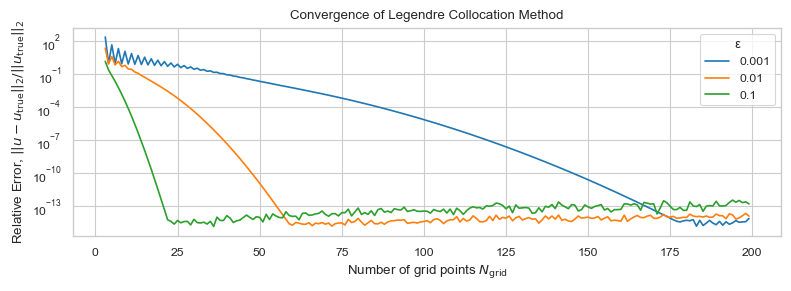

In [11]:
# For report
df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(PAPER_WIDTH_IN, 3.0))
sns.lineplot(data=df, x="N_grid", y="relative_error", hue="epsilon", palette="tab10")
plt.semilogy()

plt.title("Convergence of Legendre Collocation Method")
plt.xlabel("Number of grid points $N_\\text{grid}$")
plt.ylabel("Relative Error, $||u - u_{\\mathrm{true}}||_2 / ||u_{\\mathrm{true}}||_2$")
sns.move_legend(ax, loc="best", title="ε")
plt.tight_layout()

plt.savefig(OUTPUT_DIR / "1_a_collocation_convergence.png", dpi=EXPORT_DPI, bbox_inches='tight')

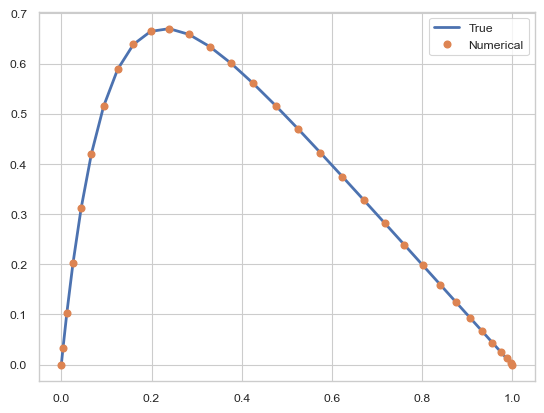

In [10]:
N = 32
P = N - 1

# Model parameters
epsilon = 0.1

z_gl = JacobiGL(alpha, beta, P)  # Includes boundaries, domain: [-1, 1]
x_gl = 0.5 * (b - a) * (z_gl + 1) + a  # Map to [a, b]
u_gl_true = u_func_1(x_gl, epsilon)

D_z = constructD(z_gl, alpha, beta)
# D_x = transform_dz_to_dx(z_gl, a, b) * D_z  # Chain rule

A = -4.0 * epsilon * np.eye(N)
B = -2.0 * np.eye(N)
C = np.zeros((N, N))

# Set up approximate operator
L_N = D_z @ A @ D_z + B @ D_z + C

# RHS
F = np.ones(N)

# Enforce BCs
L_N[0, :] = 0.0
L_N[0, 0] = 1.0
L_N[-1, :] = 0.0
L_N[-1, -1] = 1.0
F[0] = 0.0
F[-1] = 0.0

# Solve
u_gl = np.linalg.solve(L_N, F)

plt.plot(x_gl, u_gl_true, lw=2, label="True")
plt.plot(x_gl, u_gl, "o", label="Numerical")
plt.legend()
